# Setup

In [1]:
import sys
import json
import csv
import yaml

import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt

import time
from datetime import datetime

import os
from dotenv import load_dotenv

import pprint

import psycopg2
from sqlalchemy import create_engine, text as sql_text

sys.path.append('benchmarking/')
import util

In [2]:
# Load the env file 

dotenv_path = 'variables.env'
load_dotenv(dotenv_path=dotenv_path)

True

In [3]:
# Import the env variables

load_dotenv()

schema = os.getenv('DISC_4_SCHEMA')
port = os.getenv('DISC_4_PORT')
host = os.getenv('DISC_4_HOST')
database = os.getenv('DISC_4_DB')
username = os.getenv('username')
password = os.getenv('password')

In [4]:
# following https://www.geeksforgeeks.org/connecting-postgresql-with-sqlalchemy-in-python/

db_eng = create_engine(f"postgresql+psycopg2://{username}:{password}@{host}:{port}/{database}",
                       connect_args={'options': '-csearch_path={}'.format(schema)},
                       isolation_level = 'SERIALIZABLE')
#    , echo=True)
#    , echo_pool="debug")

print("Successfully created db engine.")

# connect_args is used to set search_path to the schema 'new_york_city' in the airbnb database

# isolation_level SERIALIZABLE makes transactions happen in sequence, which is good 
#      for the benchmarking we will be doing

# for general info on sqlalchemy connections,
#    see: https://docs.sqlalchemy.org/en/20/core/connections.html

# echo from https://docs.sqlalchemy.org/en/20/core/engines.html

Successfully created db engine.


# Step 4

## Helper functions

In [5]:
# Extract the avg values for each key inside each year object
def extract_avg_values(data):
    avg_values = {}
    for year, details in data.items():
        avg_values[year] = {}
        for key, metrics in details.items():
            if 'avg' in metrics:
                avg_values[year][key] = metrics['avg']
    return avg_values

In [6]:
# Extract the std values for each key inside each year object
def extract_std_values(data):
    std_values = {}
    for year, details in data.items():
        std_values[year] = {}
        for key, metrics in details.items():
            if 'std' in metrics:
                std_values[year][key] = metrics['std']
    return std_values

In [7]:
# Helper function for 3b to extract either average or std values, per word
def text_search_extract_value(data, word, value):
    values = {}
    for key, details in data.items():
        wd, year = key.split('_')
        if wd == word:
            values[year] = {}
            for k, metrics in details.items():
                if value in metrics:
                    values[year][k] = metrics[value]
    return values

## Plots for 3a

In [8]:
# Load JSON data from a file
with open('perf_data/listings_join_reviews.json', 'r') as file:
    data_listings = json.load(file)

# Printing the loaded file
#print(json.dumps(data_listings, indent=4, sort_keys=True))

In [9]:
# Renaming the keys
data_listings_renamed = util.rename_keys(data_listings)

#pprint.pp(data_listings_renamed)

In [10]:
## Listings Join Reviews Average Values per Year

# Extract the avg values
avg_values = extract_avg_values(data_listings_renamed)

#pprint.pp(avg_values)

# Map the keys to the custom labels
key_labels = {
    "__": "no_index",
    "__datetime_in_reviews__": "datetime_index",
    "__id_in_listings__": "id_index",
    "__datetime_in_reviews__id_in_listings__": "datetime_and_id_index"
}

# Prepare data for DataFrame
data_for_df = {label: [] for label in key_labels.values()}
data_for_df['Year'] = sorted(avg_values.keys())

for year in data_for_df['Year']:
    for key, label in key_labels.items():
        data_for_df[label].append(avg_values[year].get(key, None))

# Create DataFrame
df = pd.DataFrame(data_for_df)

# Set 'Year' as the index
df.set_index('Year', inplace=True)

# Display the DataFrame
print(df)

      no_index  datetime_index  id_index  datetime_and_id_index
Year                                                           
2009    0.3006          0.0156    0.2125                 0.0197
2010    0.2687          0.0211    0.2252                 0.0147
2011    0.3096          0.0233    0.2135                 0.0173
2012    0.3263          0.0193    0.2110                 0.0184
2013    0.2919          0.0235    0.2533                 0.0323
2014    0.3357          0.0331    0.2342                 0.0333
2015    0.3015          0.0530    0.3282                 0.0614
2016    0.2303          0.1094    0.3672                 0.0795
2017    0.2462          0.1511    0.3120                 0.1005
2018    0.5062          0.1539    0.5030                 0.1546
2019    0.5222          0.1949    0.5219                 0.1980
2020    0.2379          0.1612    0.3490                 0.1194
2021    0.5223          0.1765    0.5176                 0.1798
2022    0.2866          0.4000    0.2797

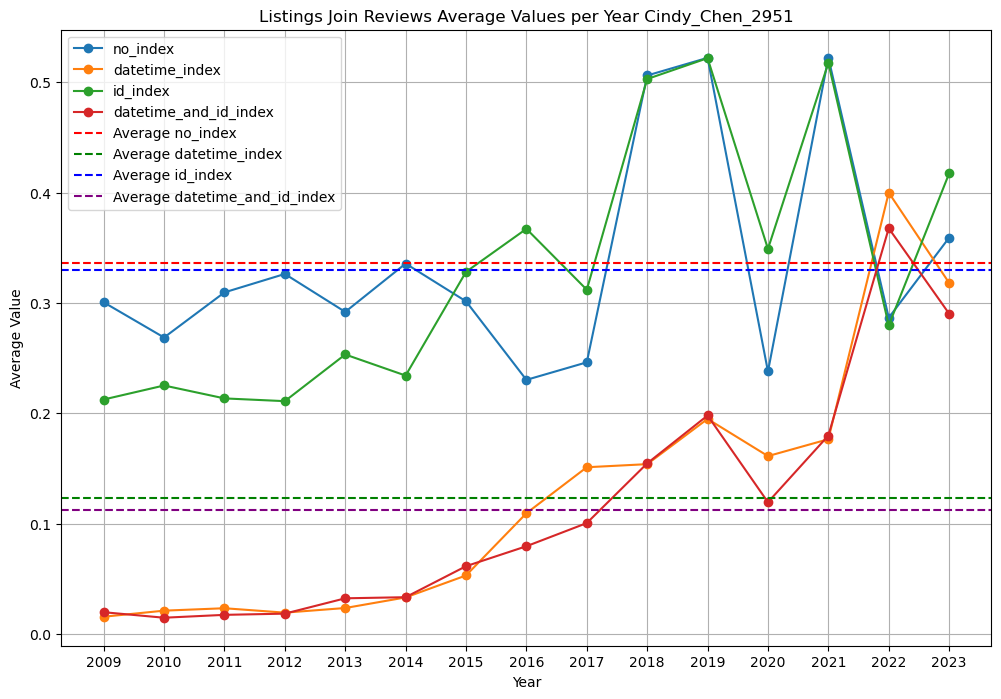

In [11]:
# Plotting the data
plt.figure(figsize=(12, 8))

# Plot each category data
for label in key_labels.values():
    plt.plot(df.index, df[label], marker='o', label=label)
    
colors = ['red', 'green', 'blue', 'purple']

# Calculate and plot average lines for each index across all years
for idx, label in enumerate(key_labels.values()):
    avg_value = df[label].mean()
    plt.axhline(y=avg_value, linestyle='--', color=colors[idx], label=f'Average {label}')

plt.title('Listings Join Reviews Average Values per Year Cindy_Chen_2951')
plt.xlabel('Year')
plt.ylabel('Average Value')
plt.legend()
plt.grid(True)
plt.show()

In [12]:
## Listings Join Reviews STD Values per Year

# Extract the avg values
std_values = extract_std_values(data_listings_renamed)

#pprint.pp(std_values)

# Map the keys to the custom labels
key_labels = {
    "__": "no_index",
    "__datetime_in_reviews__": "datetime_index",
    "__id_in_listings__": "id_index",
    "__datetime_in_reviews__id_in_listings__": "datetime_and_id_index"
}

# Prepare data for DataFrame
data_for_df = {label: [] for label in key_labels.values()}
data_for_df['Year'] = sorted(std_values.keys())

for year in data_for_df['Year']:
    for key, label in key_labels.items():
        data_for_df[label].append(std_values[year].get(key, None))

# Create DataFrame
df = pd.DataFrame(data_for_df)

# Set 'Year' as the index
df.set_index('Year', inplace=True)

# Display the DataFrame
print(df)

      no_index  datetime_index  id_index  datetime_and_id_index
Year                                                           
2009    0.5108          0.0037    0.0287                 0.0017
2010    0.0608          0.0015    0.0455                 0.0029
2011    0.0479          0.0026    0.0329                 0.0036
2012    0.0427          0.0035    0.0311                 0.0028
2013    0.0585          0.0037    0.0607                 0.0056
2014    0.0220          0.0052    0.0485                 0.0059
2015    0.0683          0.0099    0.0571                 0.0131
2016    0.0074          0.0137    0.0269                 0.0196
2017    0.0315          0.0251    0.0720                 0.0103
2018    0.0130          0.0117    0.0118                 0.0117
2019    0.0181          0.0142    0.0165                 0.0130
2020    0.0283          0.0233    0.0621                 0.0123
2021    0.0166          0.0134    0.0176                 0.0142
2022    0.0622          0.0490    0.0534

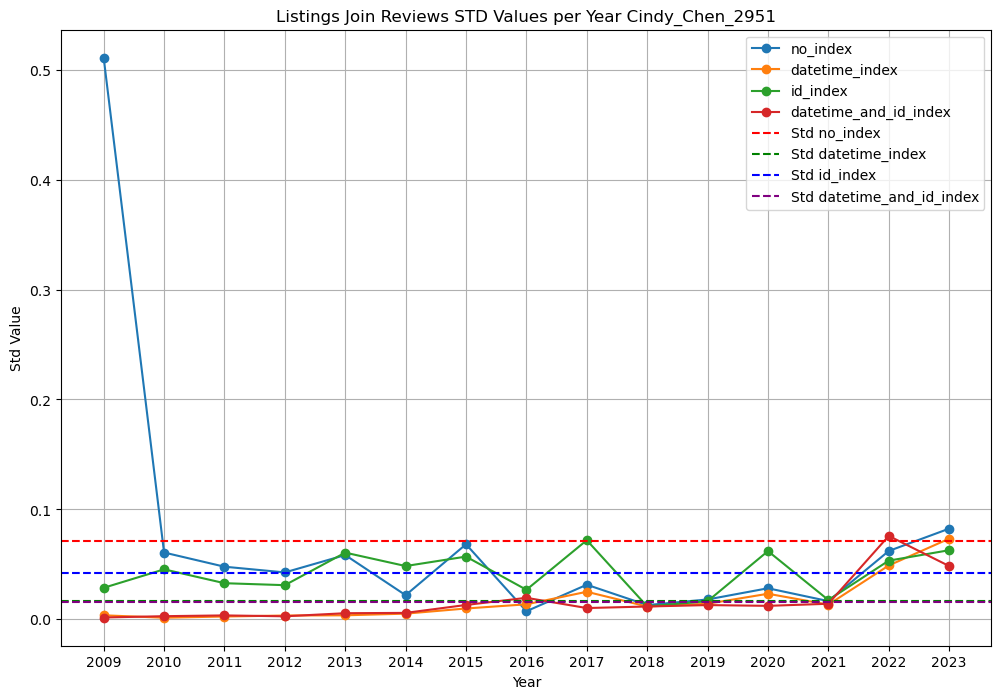

In [13]:
# Plotting the data
plt.figure(figsize=(12, 8))

# Plot each category data
for label in key_labels.values():
    plt.plot(df.index, df[label], marker='o', label=label)
    
colors = ['red', 'green', 'blue', 'purple']

# Calculate and plot average lines for each index across all years
for idx, label in enumerate(key_labels.values()):
    avg_value = df[label].mean()
    plt.axhline(y=avg_value, linestyle='--', color=colors[idx], label=f'Std {label}')

plt.title('Listings Join Reviews STD Values per Year Cindy_Chen_2951')
plt.xlabel('Year')
plt.ylabel('Std Value')
plt.legend()
plt.grid(True)
plt.show()

## Plots for 3b

In [14]:
# Load JSON data from a file
with open('perf_data/text_search_query.json', 'r') as file:
    data_listings = json.load(file)

# Printing the loaded file
print(json.dumps(data_listings, indent=4, sort_keys=True))

{
    "apartment_2009": {
        "__": {
            "avg": 0.7045,
            "exec_count": 50,
            "max": 5.1288,
            "min": 0.525,
            "std": 0.7642,
            "timestamp": "2024-05-20-17:34:04"
        },
        "__comments_tsv_in_reviews__": {
            "avg": 0.4085,
            "exec_count": 50,
            "max": 0.8454,
            "min": 0.3537,
            "std": 0.1036,
            "timestamp": "2024-05-20-17:34:24"
        },
        "__datetime_in_reviews__": {
            "avg": 0.0023,
            "exec_count": 50,
            "max": 0.007,
            "min": 0.0017,
            "std": 0.0008,
            "timestamp": "2024-05-20-17:34:25"
        },
        "__datetime_in_reviews__comments_tsv_in_reviews__": {
            "avg": 0.0389,
            "exec_count": 50,
            "max": 0.0404,
            "min": 0.0358,
            "std": 0.0007,
            "timestamp": "2024-05-20-17:34:27"
        }
    },
    "apartment_2010": {
      

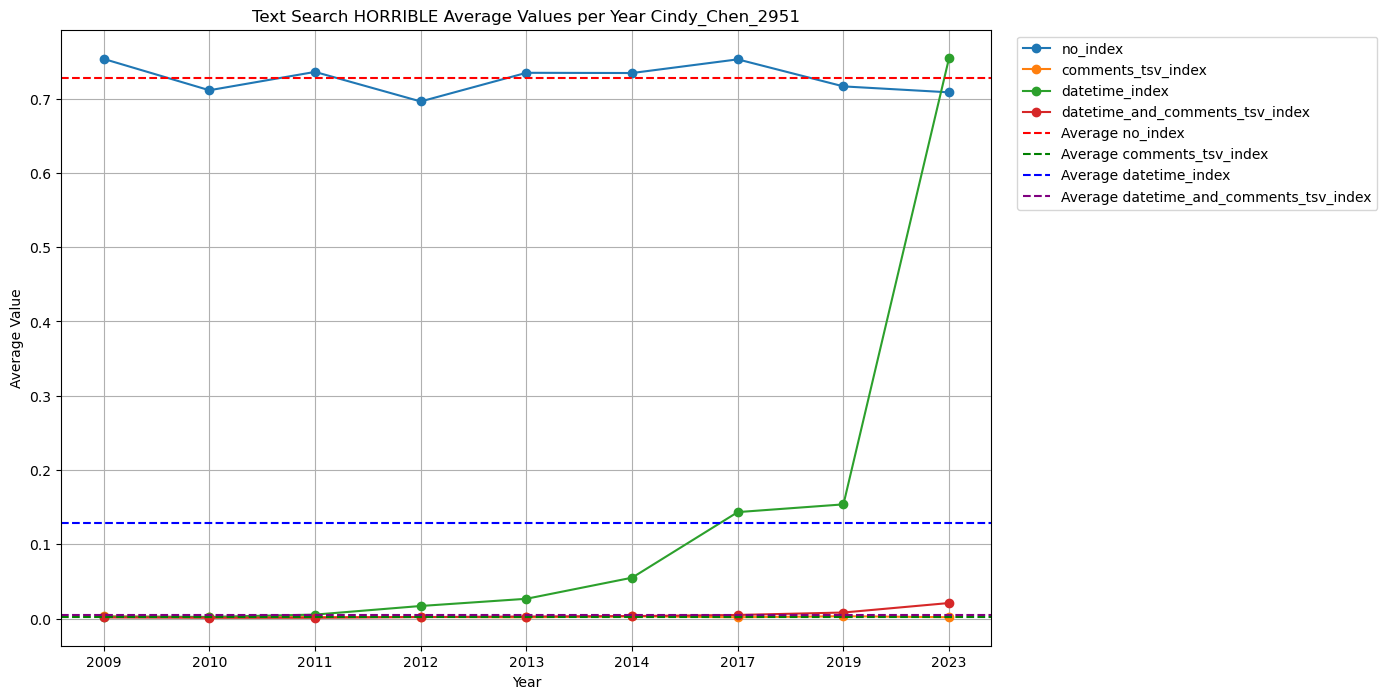

In [15]:
## Text Search HORRIBLE Average Values per Year

# Create dataframe for horrible average values
df = pd.DataFrame(text_search_extract_value(data_listings, 'horrible', 'avg')).T

# Rename columns
df.rename(columns = {"__": "no_index",
    "__datetime_in_reviews__": "datetime_index",
    "__comments_tsv_in_reviews__": "comments_tsv_index",
    "__datetime_in_reviews__comments_tsv_in_reviews__": "datetime_and_comments_tsv_index"}
    , inplace = True)

# Plotting the data
plt.figure(figsize=(12, 8))

# plot each index data
for col in df.columns:
    plt.plot(df[col], label=col, marker='o')

colors = ['red', 'green', 'blue', 'purple']

# calcualte and plot average lines for ech index across all years
for i, col in enumerate(df.columns):
    avg = df[col].mean()
    plt.axhline(avg, color=colors[i], linestyle='--', label=f'Average {col}')

plt.title('Text Search HORRIBLE Average Values per Year Cindy_Chen_2951')
plt.xlabel('Year')
plt.ylabel('Average Value')
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
plt.grid(True)
plt.show()

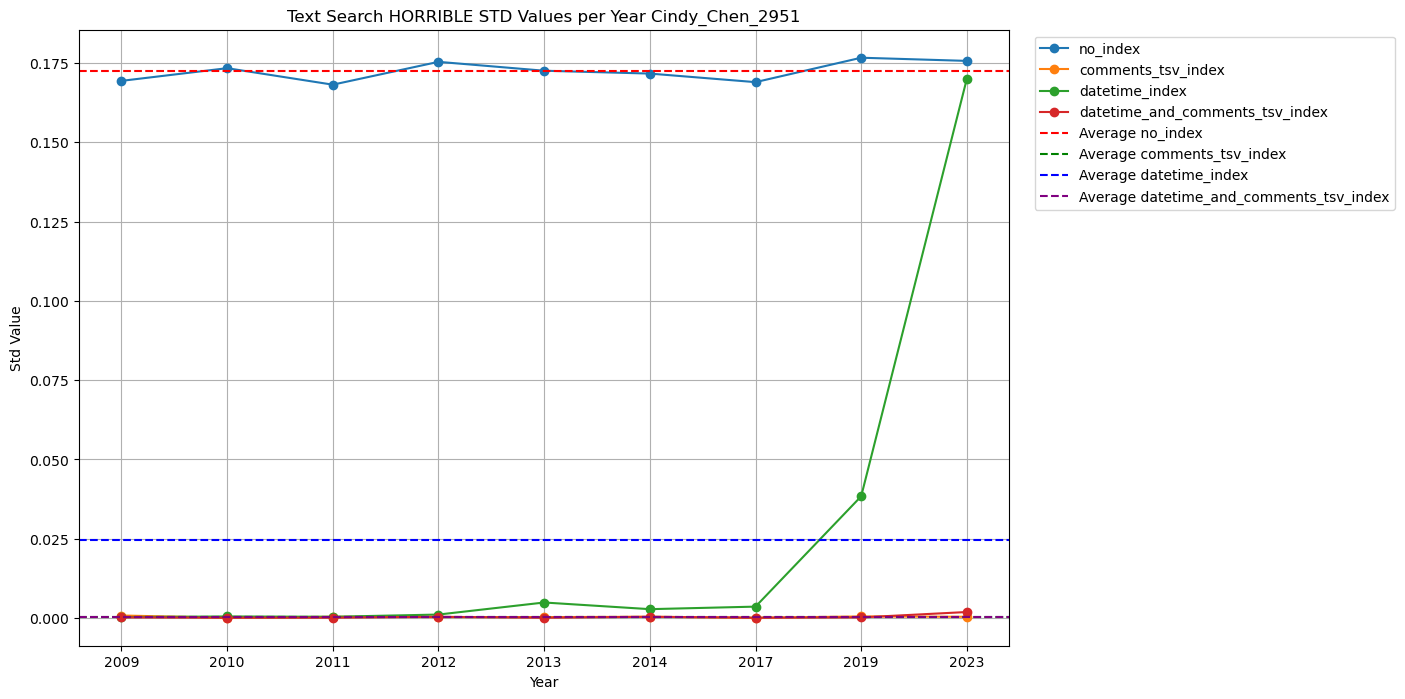

In [16]:
## Text Search HORRIBLE STD Values per Year

# Create dataframe for horrible std values
df = pd.DataFrame(text_search_extract_value(data_listings, 'horrible', 'std')).T

# Rename columns
df.rename(columns = {"__": "no_index",
    "__datetime_in_reviews__": "datetime_index",
    "__comments_tsv_in_reviews__": "comments_tsv_index",
    "__datetime_in_reviews__comments_tsv_in_reviews__": "datetime_and_comments_tsv_index"}
    , inplace = True)

# Plotting the data
plt.figure(figsize=(12, 8))

# plot each index data
for col in df.columns:
    plt.plot(df[col], label=col, marker='o')

colors = ['red', 'green', 'blue', 'purple']

# calcualte and plot average lines for ech index across all years
for i, col in enumerate(df.columns):
    avg = df[col].mean()
    plt.axhline(avg, color=colors[i], linestyle='--', label=f'Average {col}')

plt.title('Text Search HORRIBLE STD Values per Year Cindy_Chen_2951')
plt.xlabel('Year')
plt.ylabel('Std Value')
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
plt.grid(True)
plt.show()

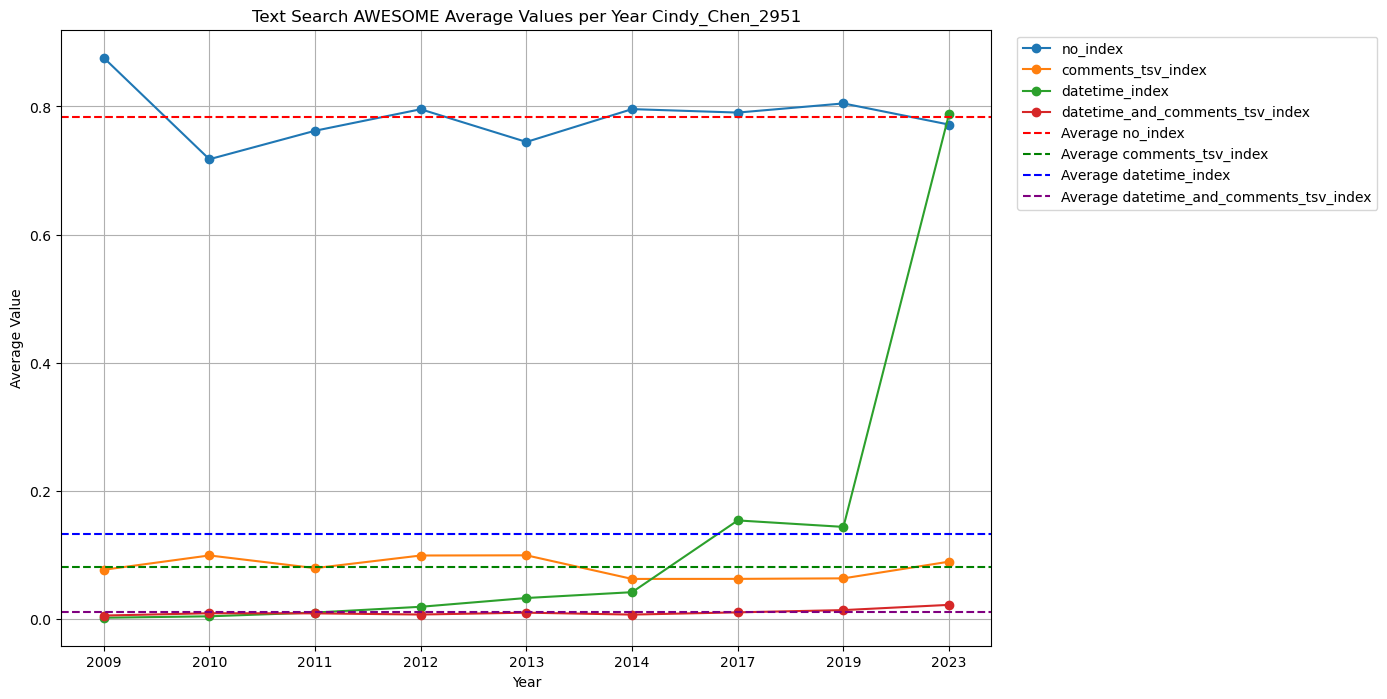

In [17]:
## Text Search AWESOME Average Values per Year

# Create dataframe for awesome average values
df = pd.DataFrame(text_search_extract_value(data_listings, 'awesome', 'avg')).T

# Rename columns
df.rename(columns = {"__": "no_index",
    "__datetime_in_reviews__": "datetime_index",
    "__comments_tsv_in_reviews__": "comments_tsv_index",
    "__datetime_in_reviews__comments_tsv_in_reviews__": "datetime_and_comments_tsv_index"}
    , inplace = True)

# Plotting the data
plt.figure(figsize=(12, 8))

# plot each index data
for col in df.columns:
    plt.plot(df[col], label=col, marker='o')

colors = ['red', 'green', 'blue', 'purple']

# calcualte and plot average lines for ech index across all years
for i, col in enumerate(df.columns):
    avg = df[col].mean()
    plt.axhline(avg, color=colors[i], linestyle='--', label=f'Average {col}')

plt.title('Text Search AWESOME Average Values per Year Cindy_Chen_2951')
plt.xlabel('Year')
plt.ylabel('Average Value')
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
plt.grid(True)
plt.show()

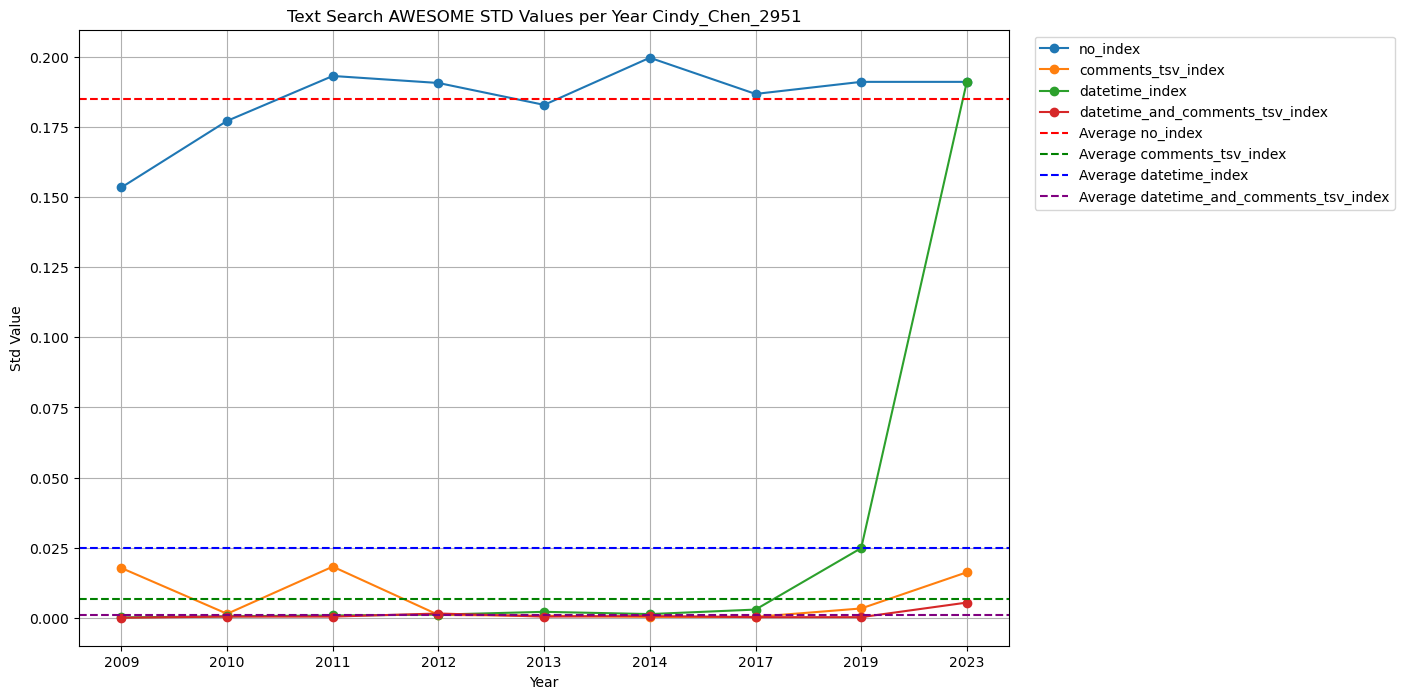

In [18]:
## Text Search AWESOME STD Values per Year

# Create dataframe for awesome STD values
df = pd.DataFrame(text_search_extract_value(data_listings, 'awesome', 'std')).T

# Rename columns
df.rename(columns = {"__": "no_index",
    "__datetime_in_reviews__": "datetime_index",
    "__comments_tsv_in_reviews__": "comments_tsv_index",
    "__datetime_in_reviews__comments_tsv_in_reviews__": "datetime_and_comments_tsv_index"}
    , inplace = True)

# Plotting the data
plt.figure(figsize=(12, 8))

# plot each index data
for col in df.columns:
    plt.plot(df[col], label=col, marker='o')

colors = ['red', 'green', 'blue', 'purple']

# calcualte and plot average lines for ech index across all years
for i, col in enumerate(df.columns):
    avg = df[col].mean()
    plt.axhline(avg, color=colors[i], linestyle='--', label=f'Average {col}')

plt.title('Text Search AWESOME STD Values per Year Cindy_Chen_2951')
plt.xlabel('Year')
plt.ylabel('Std Value')
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
plt.grid(True)
plt.show()

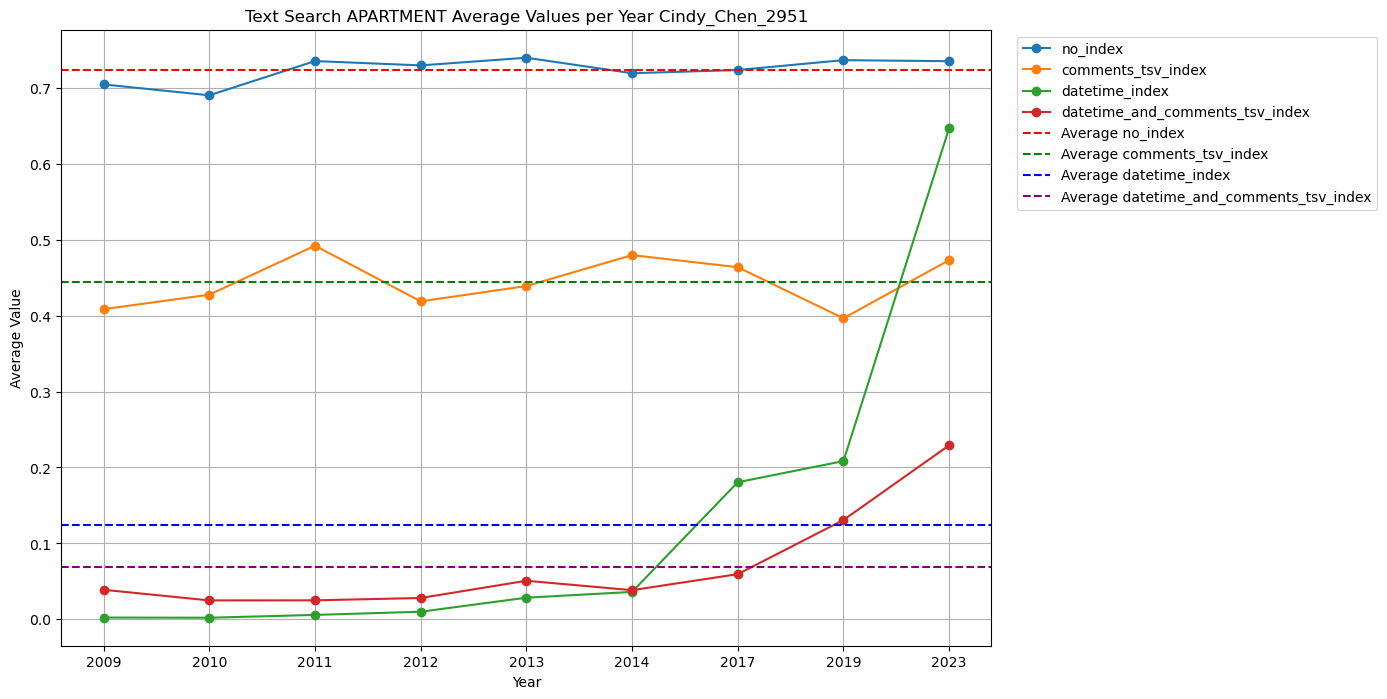

In [19]:
## Text Search APARTMENT Average Values per Year

# Create dataframe for apartment average values
df = pd.DataFrame(text_search_extract_value(data_listings, 'apartment', 'avg')).T

# Rename columns
df.rename(columns = {"__": "no_index",
    "__datetime_in_reviews__": "datetime_index",
    "__comments_tsv_in_reviews__": "comments_tsv_index",
    "__datetime_in_reviews__comments_tsv_in_reviews__": "datetime_and_comments_tsv_index"}
    , inplace = True)

# Plotting the data
plt.figure(figsize=(12, 8))

# plot each index data
for col in df.columns:
    plt.plot(df[col], label=col, marker='o')

colors = ['red', 'green', 'blue', 'purple']

# calcualte and plot average lines for ech index across all years
for i, col in enumerate(df.columns):
    avg = df[col].mean()
    plt.axhline(avg, color=colors[i], linestyle='--', label=f'Average {col}')

plt.title('Text Search APARTMENT Average Values per Year Cindy_Chen_2951')
plt.xlabel('Year')
plt.ylabel('Average Value')
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
plt.grid(True)
plt.show()

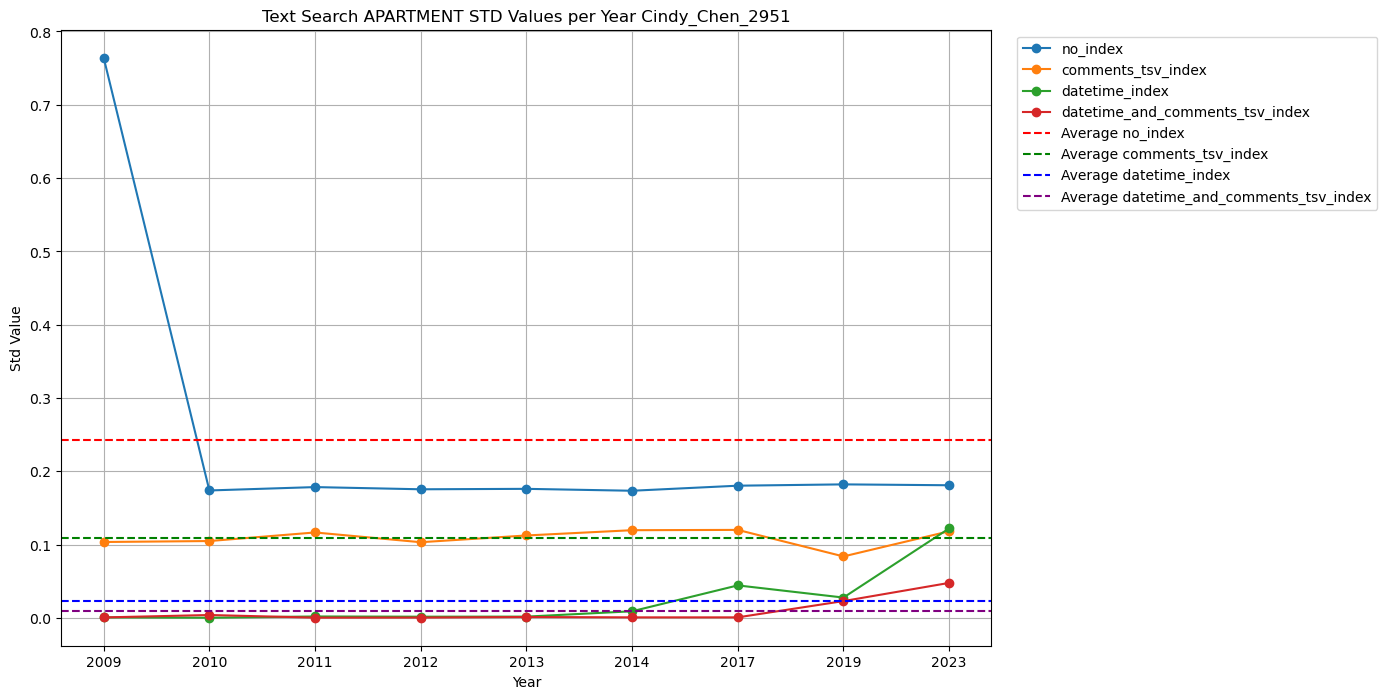

In [20]:
## Text Search APARTMENT STD Values per Year

# Create dataframe for apartment STD values
df = pd.DataFrame(text_search_extract_value(data_listings, 'apartment', 'std')).T

# Rename columns
df.rename(columns = {"__": "no_index",
    "__datetime_in_reviews__": "datetime_index",
    "__comments_tsv_in_reviews__": "comments_tsv_index",
    "__datetime_in_reviews__comments_tsv_in_reviews__": "datetime_and_comments_tsv_index"}
    , inplace = True)

# Plotting the data
plt.figure(figsize=(12, 8))

# plot each index data
for col in df.columns:
    plt.plot(df[col], label=col, marker='o')

colors = ['red', 'green', 'blue', 'purple']

# calcualte and plot average lines for ech index across all years
for i, col in enumerate(df.columns):
    avg = df[col].mean()
    plt.axhline(avg, color=colors[i], linestyle='--', label=f'Average {col}')

plt.title('Text Search APARTMENT STD Values per Year Cindy_Chen_2951')
plt.xlabel('Year')
plt.ylabel('Std Value')
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
plt.grid(True)
plt.show()

## Plots for 3c

In [21]:
# Load JSON data from a file
with open('perf_data/update_datetimes_query.json', 'r') as file:
    data_listings = json.load(file)

# Printing the loaded file
print(json.dumps(data_listings, indent=4, sort_keys=True))

{
    "update_datetimes_query_Bedford-Stuyvesant": {
        "__": {
            "avg": 18.3241,
            "count": 50,
            "max": 42.9542,
            "min": 8.8363,
            "std": 6.9992,
            "timestamp": "2024-05-21-14:27:12"
        },
        "__datetime_in_reviews__": {
            "avg": 25.5835,
            "count": 50,
            "max": 34.1286,
            "min": 15.7481,
            "std": 4.1935,
            "timestamp": "2024-05-21-14:42:37"
        },
        "__neigh_in_listings__": {
            "avg": 17.9937,
            "count": 50,
            "max": 25.2202,
            "min": 11.4883,
            "std": 3.6245,
            "timestamp": "2024-05-21-15:03:57"
        },
        "__neigh_in_listings__datetime_in_reviews__": {
            "avg": 25.6714,
            "count": 50,
            "max": 40.1678,
            "min": 17.4479,
            "std": 4.6606,
            "timestamp": "2024-05-21-15:19:06"
        }
    },
    "update_datetimes_

In [22]:
def rename_keys_location(data):
    new_data = {}
    for key, value in data.items():
        if key.startswith("update_datetimes_query"):
            location = key.split("_")[-1]
            new_data[location] = value
        else:
            new_data[key] = value
    return new_data

In [23]:
# Rename keys to location
data_listings_renamed = rename_keys_location(data_listings)

In [24]:
## Update Datetimes Query Average Values per Location

# Extract the avg values
avg_values = extract_avg_values(data_listings_renamed)

#pprint.pp(avg_values)

# Map the keys to the custom labels
key_labels = {"__": "no_index",
    "__datetime_in_reviews__": "datetime_index",
    "__neigh_in_listings__": "neigh_index",
    "__neigh_in_listings__datetime_in_reviews__": "datetime_and_neigh_index"}

# Prepare data for DataFrame
data_for_df = {label: [] for label in key_labels.values()}
data_for_df['Location'] = sorted(avg_values.keys())

for year in data_for_df['Location']:
    for key, label in key_labels.items():
        data_for_df[label].append(avg_values[year].get(key, None))

# Create DataFrame
df = pd.DataFrame(data_for_df)

# Set 'Year' as the index
df.set_index('Location', inplace=True)

axis_order = ['New Springville', 'Fort Hamilton', 'Long Island City', 'Bedford-Stuyvesant', 'Staten Island', 'Bronx', 'Queens', 'Manhattan']
df = df.reindex(axis_order)
# Display the DataFrame
print(df)

                    no_index  datetime_index  neigh_index  \
Location                                                    
New Springville       0.5068          0.5017       0.5032   
Fort Hamilton         0.5564          0.5559       0.6539   
Long Island City      1.1966          1.6072       1.6905   
Bedford-Stuyvesant   18.3241         25.5835      17.9937   
Staten Island         2.2294          2.0948       2.3030   
Bronx                10.3006         12.9968       9.7783   
Queens               34.5601         44.4125      38.2253   
Manhattan            69.7548         94.4771      86.9042   

                    datetime_and_neigh_index  
Location                                      
New Springville                       0.4907  
Fort Hamilton                         0.5312  
Long Island City                      1.7206  
Bedford-Stuyvesant                   25.6714  
Staten Island                         3.3373  
Bronx                                13.0381  
Queens       

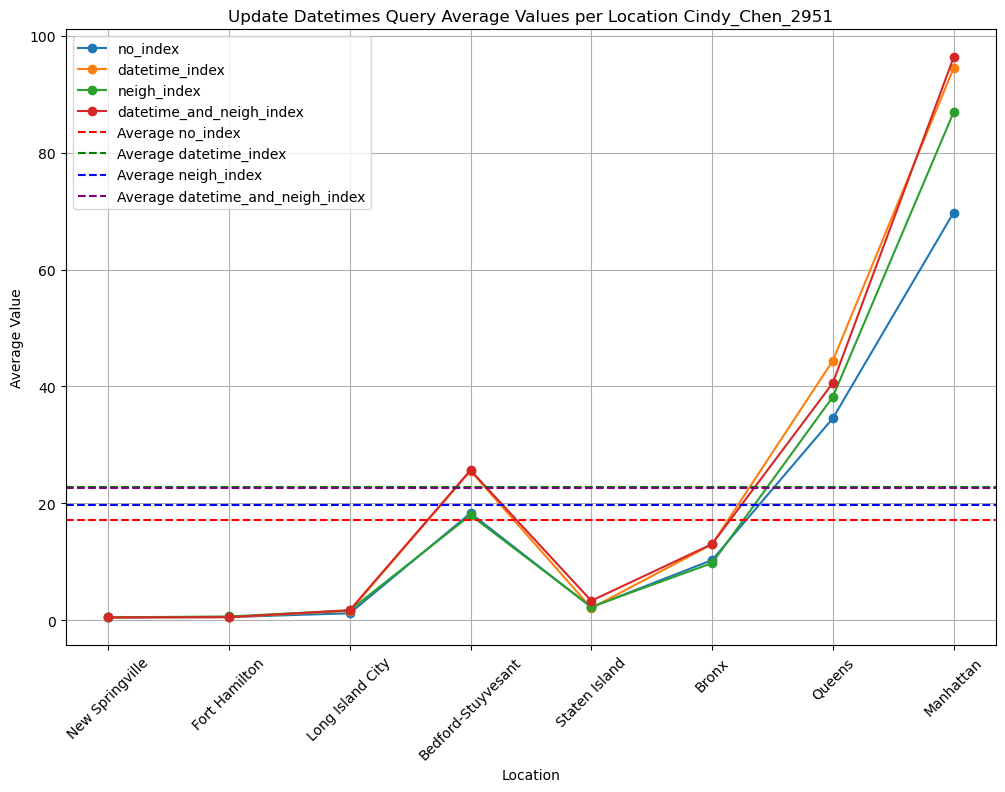

In [25]:
# Plotting the data
plt.figure(figsize=(12, 8))

# Plot each category data
for label in key_labels.values():
    plt.plot(df.index, df[label], marker='o', label=label)
    
colors = ['red', 'green', 'blue', 'purple']

# Calculate and plot average lines for each index across all years
for idx, label in enumerate(key_labels.values()):
    avg_value = df[label].mean()
    plt.axhline(y=avg_value, linestyle='--', color=colors[idx], label=f'Average {label}')

plt.title('Update Datetimes Query Average Values per Location Cindy_Chen_2951')
plt.xlabel('Location')
plt.xticks(rotation=45)
plt.ylabel('Average Value')
plt.legend()
plt.grid(True)
plt.show()

In [26]:
## Update Datetimes Query STD Values per Location

# Extract the std values
std_values = extract_std_values(data_listings_renamed)

#pprint.pp(avg_values)

# Map the keys to the custom labels
key_labels = {"__": "no_index",
    "__datetime_in_reviews__": "datetime_index",
    "__neigh_in_listings__": "neigh_index",
    "__neigh_in_listings__datetime_in_reviews__": "datetime_and_neigh_index"}

# Prepare data for DataFrame
data_for_df = {label: [] for label in key_labels.values()}
data_for_df['Location'] = sorted(std_values.keys())

for year in data_for_df['Location']:
    for key, label in key_labels.items():
        data_for_df[label].append(std_values[year].get(key, None))

# Create DataFrame
df = pd.DataFrame(data_for_df)

# Set 'Year' as the index
df.set_index('Location', inplace=True)

axis_order = ['New Springville', 'Fort Hamilton', 'Long Island City', 'Bedford-Stuyvesant', 'Staten Island', 'Bronx', 'Queens', 'Manhattan']
df = df.reindex(axis_order)
# Display the DataFrame
print(df)

                    no_index  datetime_index  neigh_index  \
Location                                                    
New Springville       0.0897          0.0156       0.0718   
Fort Hamilton         0.1877          0.1246       0.1738   
Long Island City      0.3444          0.4388       0.8213   
Bedford-Stuyvesant    6.9992          4.1935       3.6245   
Staten Island         1.5756          0.6005       0.7050   
Bronx                 3.3919          3.0387       1.9842   
Queens               11.3650          4.7014       9.6275   
Manhattan            18.4688         18.6466      32.2655   

                    datetime_and_neigh_index  
Location                                      
New Springville                       0.0225  
Fort Hamilton                         0.0538  
Long Island City                      0.5123  
Bedford-Stuyvesant                    4.6606  
Staten Island                         1.7996  
Bronx                                 3.0869  
Queens       

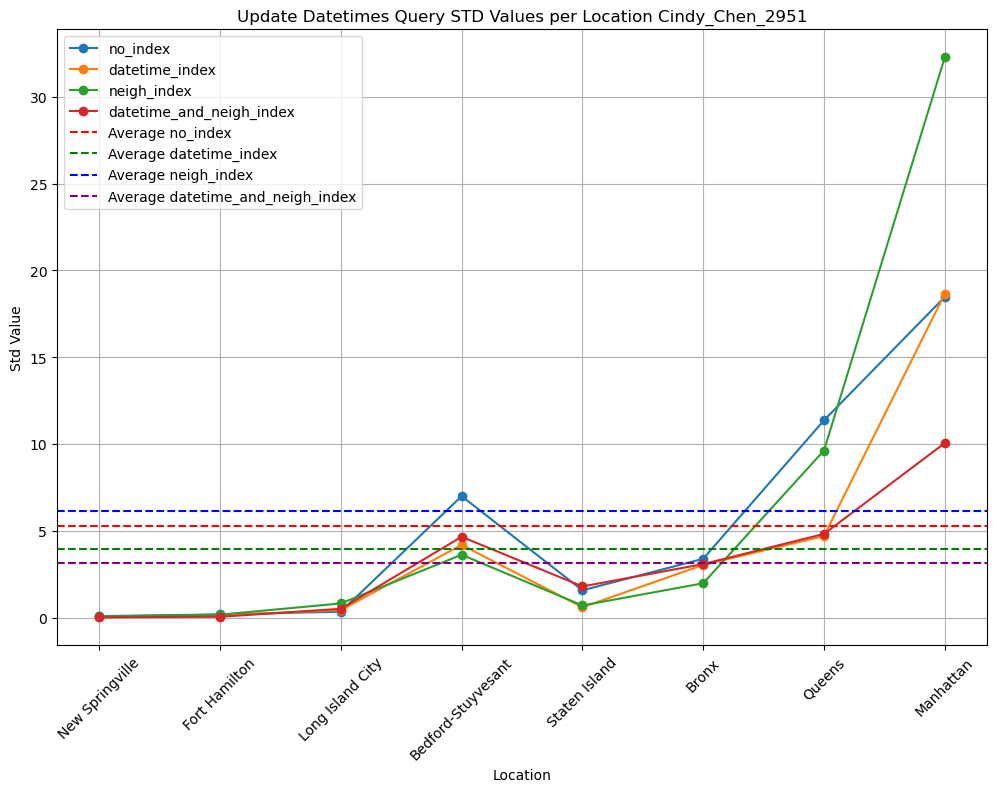

In [27]:
# Plotting the data
plt.figure(figsize=(12, 8))

# Plot each category data
for label in key_labels.values():
    plt.plot(df.index, df[label], marker='o', label=label)
    
colors = ['red', 'green', 'blue', 'purple']

# Calculate and plot average lines for each index across all years
for idx, label in enumerate(key_labels.values()):
    avg_value = df[label].mean()
    plt.axhline(y=avg_value, linestyle='--', color=colors[idx], label=f'Average {label}')

plt.title('Update Datetimes Query STD Values per Location Cindy_Chen_2951')
plt.xlabel('Location')
plt.xticks(rotation=45)
plt.ylabel('Std Value')
plt.legend()
plt.grid(True)
plt.show()